In [202]:
import numpy as np
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from pathlib import Path

In [254]:
def load_slideseq_puck(puck_directory):
    # Load the counts and positions
    counts_file = puck_directory / "MappedDGEForR.csv"
    pos_file = puck_directory / "BeadLocationsForR.csv"

    pos = pd.read_csv(pos_file, index_col=0)
    counts = pd.read_csv(counts_file, index_col=0) # Takes a while, ~10min

    # Align the indices
    counts = counts.loc[:, pos.index]
    barcodes = pos.index.values

    # Swap position axes
    # We swap x'=y and y'=-x to match the slides in the paper
    pos = pd.DataFrame(
        {
            'X': pos.ycoord,
            'Y': pos.xcoord*-1,
        }, index=pos.index
    )

#     num_umi = counts.sum(axis=0)

    return counts, pos

In [257]:
stacked_counts = []
stacked_pos = []
for slice_number in ["13", "17", "18", "19", "22", "23"]:
    counts, pos = load_slideseq_puck(puck_directory / f"Puck_180531_{slice_number}")
    stacked_counts.append(counts)
    stacked_pos.append(pos)

KeyboardInterrupt: 

In [3]:
# Filter genes
gene_counts = (counts > 0).sum(axis=1)
valid_genes = gene_counts >= 50
counts = counts.loc[valid_genes]

NameError: name 'counts' is not defined

## Loading the pseudo-3D Slide-seq dataset

In [2]:
puck_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/slideseq/hippocampal_pseudo_3D/")

### Preprocessed STAGATE version...

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#import STAGATE_pyG

data = pd.read_csv(puck_directory / "STAGATE_preprocessed" /'3D_Hippo_expression.txt', sep='\t', index_col=0)
Aligned_coor = pd.read_csv(puck_directory / "STAGATE_preprocessed" / 'ICP_Align_Coor.txt', sep='\t', index_col=0)

Aligned_coor.head()

adata = sc.AnnData(data)
adata

AnnData object with n_obs × n_vars = 10908 × 9420

In [9]:
adata.obs['X'] = Aligned_coor.loc[adata.obs_names, 'X']
adata.obs['Y'] = Aligned_coor.loc[adata.obs_names, 'Y']
adata.obs['Z'] = Aligned_coor.loc[adata.obs_names, 'Z']
adata.obs['Section_id'] = Aligned_coor.loc[adata.obs_names, 'Section']

In [6]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 10908 × 9420
    obs: 'X', 'Y', 'Z', 'Section_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [11]:
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y']].values

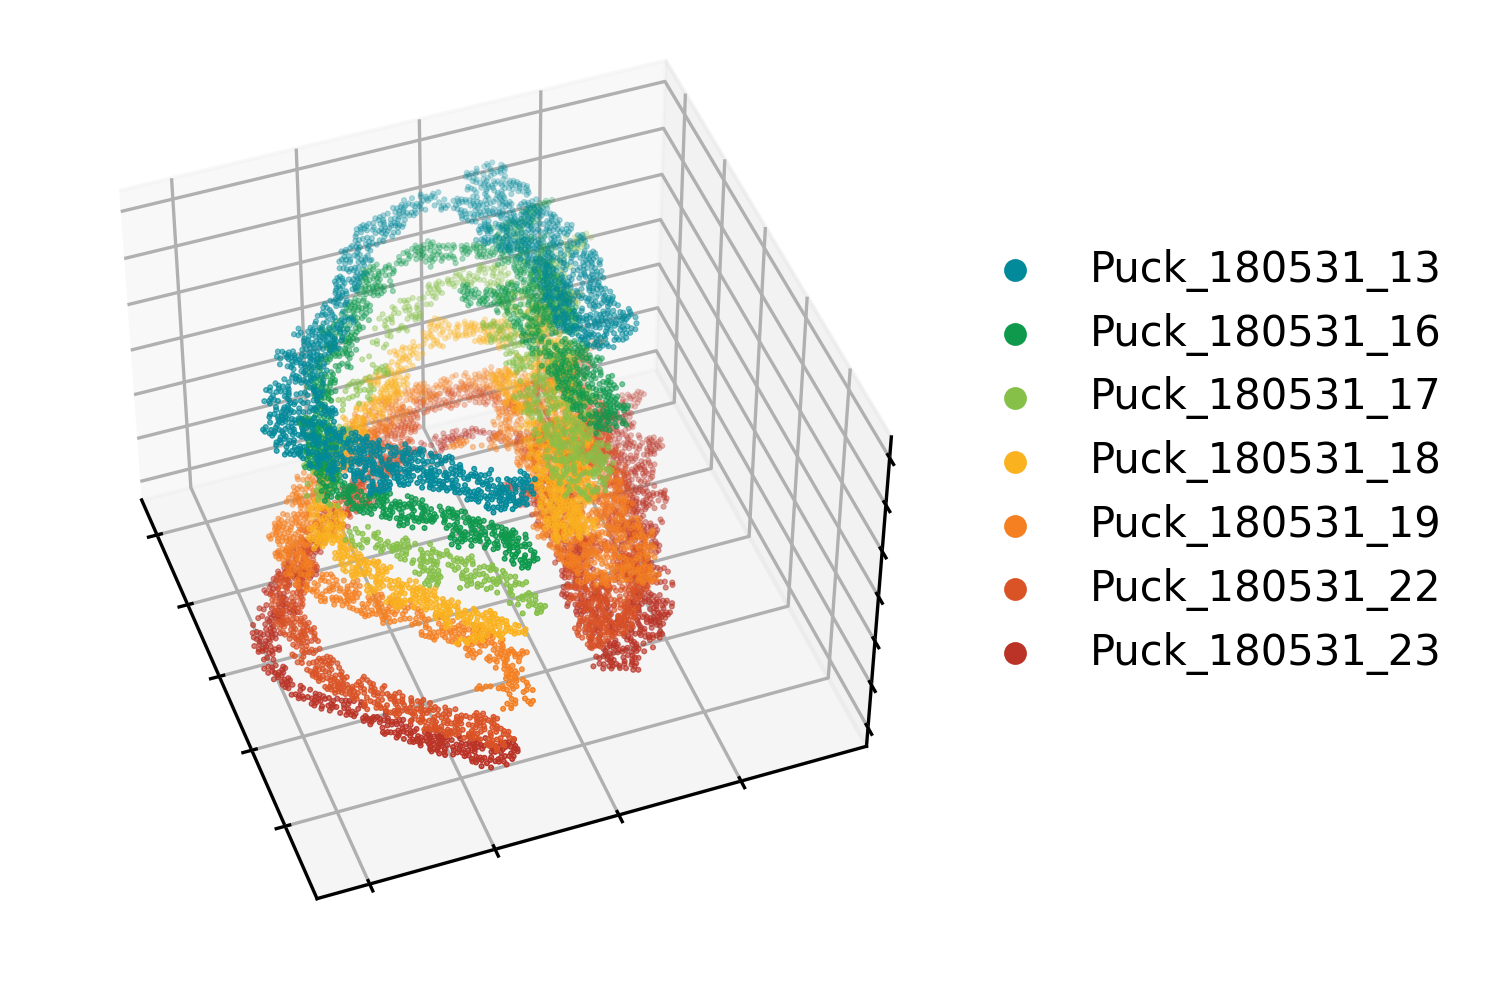

In [13]:
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
fig = plt.figure(figsize=(4, 4), dpi=300)
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(adata.obs['Section_id'])):
    temp_Coor = adata.obs.loc[adata.obs['Section_id']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=section_colors[it],s=0.2, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20

plt.show()

## Simulating realistic spatial patterns across FOVs

In [15]:
data_directory = Path("../../data/squidpy_datasets/")
adata = sq.datasets.merfish(data_directory)
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color="Cell_class")

  0%|          | 0.00/49.2M [00:00<?, ?B/s]

KeyboardInterrupt: 

## Exploring BGI Stereo-seq mouse embryo

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
mouse_embryo = pd.read_csv("../../data/stereoseq/mouse_embryo_development/E10.5_E1S3_GEM_bin1.tsv", delimiter="\t", nrows=30000)

In [19]:
mouse_embryo

,geneID,x,y,MIDCounts
0,0610005C13Rik,3614,7988,1
1,0610005C13Rik,7811,8950,1
2,0610005C13Rik,7611,4790,1
3,0610005C13Rik,7478,3573,1
4,0610005C13Rik,5361,7425,1
...,...,...,...,...
29995,0610010K14Rik,7773,3124,1
29996,0610010K14Rik,5542,7198,1
29997,0610010K14Rik,6341,6955,1
29998,0610010K14Rik,8058,5567,1


In [21]:
mouse_embryo_slice = ad.read_h5ad("../../data/stereoseq/mouse_embryo_development/E16.5_E1S1.MOSTA.h5ad")

In [22]:
mouse_embryo_slice_2 = ad.read_h5ad("../../data/stereoseq/mouse_embryo_development/E16.5_E1S2.MOSTA.h5ad")

In [123]:
np.sort(mouse_embryo_slice.obs["annotation"].unique())

array(['Adipose tissue', 'Adrenal gland', 'Bone', 'Brain', 'Cartilage',
       'Cartilage primordium', 'Cavity', 'Choroid plexus',
       'Connective tissue', 'Dorsal root ganglion', 'Epidermis',
       'GI tract', 'Heart', 'Inner ear', 'Jaw and tooth', 'Kidney',
       'Liver', 'Lung', 'Meninges', 'Mucosal epithelium', 'Muscle',
       'Smooth muscle', 'Spinal cord', 'Submandibular gland',
       'Sympathetic nerve'], dtype=object)

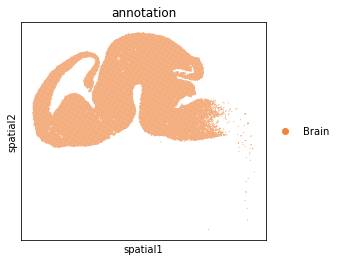

In [85]:
# x, y = mouse_embryo_slice.obsm["spatial"][:].T
# fig = plt.figure()
# ax = fig.add_subplot(111, aspect="equal")
# plt.scatter(x, y, s=0.01)
sc.pl.spatial(mouse_embryo_slice[mouse_embryo_slice.obs["annotation"] == "Brain"],
              color="annotation",
              spot_size=1)

In [96]:
from scipy.sparse import csr_matrix
def remove_connectivity_artifacts(sparse_distance_matrix):
    dense_distances = sparse_distance_matrix.toarray()
    distances = sparse_distance_matrix.data
    cutoff = np.percentile(distances, 94.5)
    mask = dense_distances < cutoff
    
    return csr_matrix(dense_distances * mask)

def compute_neighborhood_enrichment(anndata_replicate, key):
    print("Constructing neighbors")
    sq.gr.spatial_neighbors(anndata_replicate, delaunay=True, coord_type="generic")
    
#     print("Removing artifacts")
#     anndata_replicate.obsp["spatial_connectivities"] = remove_connectivity_artifacts(anndata_replicate.obsp["spatial_connectivities"])
#     sc.pl.spatial(mouse_embryo_slice,
#                   neighbors_key="spatial_neighbors",
#                   color="annotation",
#                   edges=True,
#                   spot_size=1)

    print("Computing enrichment")
    sq.gr.nhood_enrichment(anndata_replicate,
                       cluster_key="annotation")
    
    return anndata_replicate

In [97]:
mouse_embryo_slice = compute_neighborhood_enrichment(mouse_embryo_slice, "annotation")

Constructing neighbors
Computing enrichment


  0%|          | 0/1000 [00:00<?, ?/s]

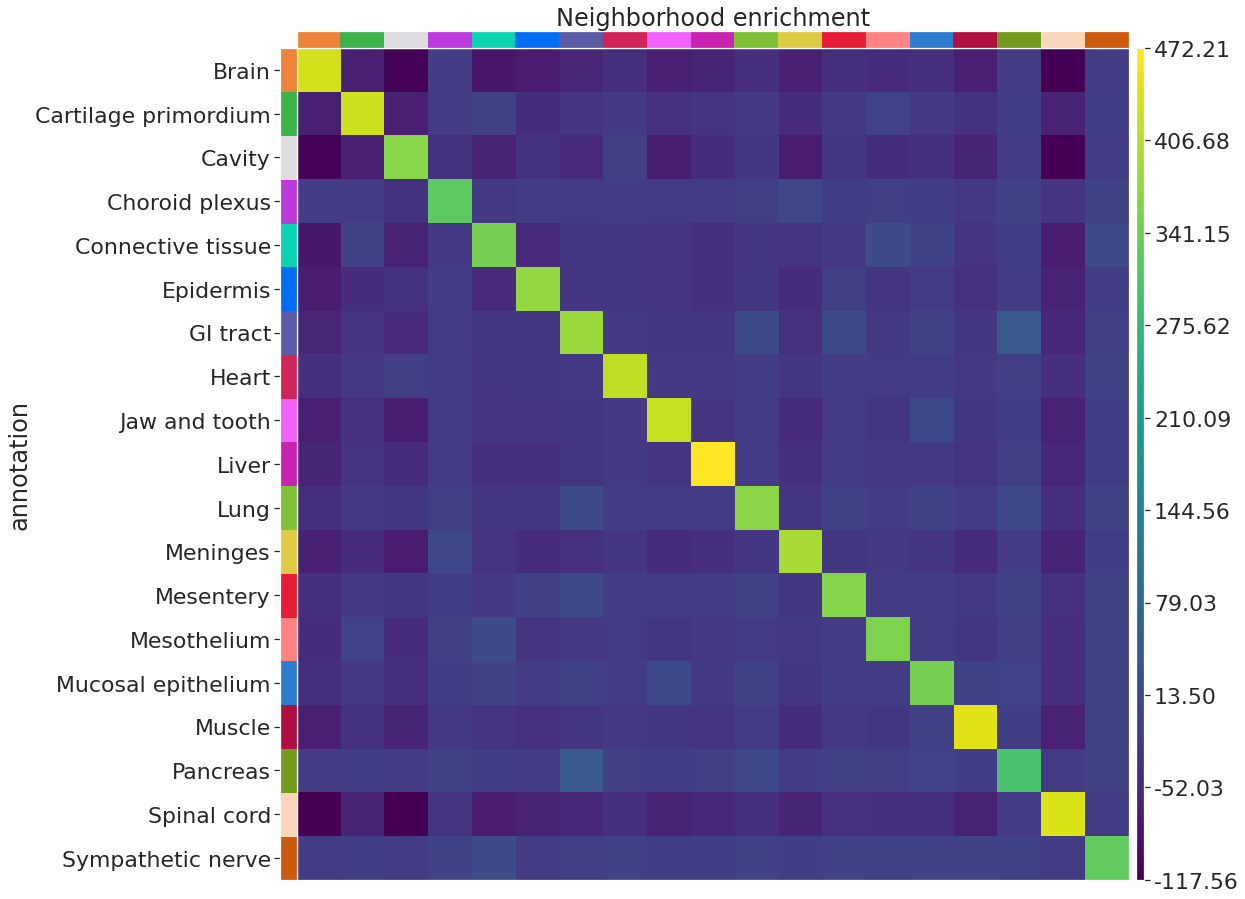

In [201]:
sq.pl.nhood_enrichment(mouse_embryo_slice,
                       cluster_key="annotation")

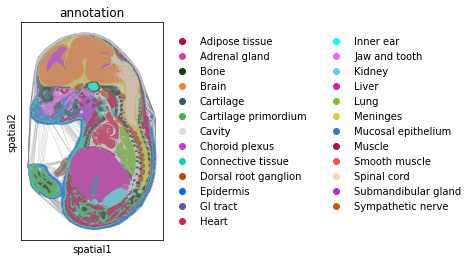

In [99]:
sc.pl.spatial(mouse_embryo_slice,
              neighbors_key="spatial_neighbors",
              color="annotation",
              edges=True,
              spot_size=1)

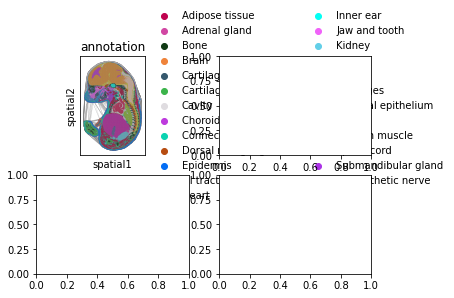

In [120]:
# sq.gr.spatial_neighbors(mouse_embryo_slice, delaunay=True, coord_type="generic")
# sq.gr.nhood_enrichment(mouse_embryo_slice,
#                        cluster_key="annotation")
fig, axes = plt.subplots(2, 2)
# sq.pl.nhood_enrichment(mouse_embryo_slice,
#                        cluster_key="annotation", ax=axes[0, 1])
sc.pl.spatial(mouse_embryo_slice,
              neighbors_key="spatial_neighbors",
              color="annotation",
              spot_size=1,
              ax = axes[0, 0])

In [107]:
# sc.metrics.morans_i(mouse_embryo_slice, use_graph="spatial_neighbors", obsm="annotation")
def compute_spatial_statistic_over_classes(anndata, key, statistic_function=sc.metrics.morans_i):
    statistics = {}
    classes = anndata.obs["annotation"].unique()
    for unique_class in classes:
        statistic = statistic_function(anndata.obsp["spatial_connectivities"], anndata.obs["annotation"] == unique_class)
        statistics[unique_class] = statistic
        
    return statistics

morans_i = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.morans_i)
gearys_c = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.gearys_c)

In [ ]:
data_directory = Path("../../data/stereoseq/mouse_embryo_development/")
neighborhood_enrichments = {}
tissues = {}
morans_i = {}
gearys_c = {}
for file in data_directory.glob("*E1S1*.h5ad"):
    print(file)
    mouse_embryo_slice = ad.read_h5ad(file)
    mouse_embryo_slice = compute_neighborhood_enrichment(mouse_embryo_slice, "annotation")
    neighborhood_enrichments[file.stem] = mouse_embryo_slice.uns['annotation_nhood_enrichment']['zscore']
    neighborhood_enrichments[file.stem] = np.sort(mouse_embryo_slice.obs["annotation"].unique())
    sq.pl.nhood_enrichment(mouse_embryo_slice,
                           cluster_key="annotation")
    morans_i[file.stem] = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.morans_i)
    gearys_c[file.stem] = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.gearys_c)

In [ ]:
filename_to_timepoint = {
    "E9.5_E1S1.MOSTA": 9.5,
    "E10.5_E1S1.MOSTA": 10.5,
    "E11.5_E1S1.MOSTA": 11.5,
    "E12.5_E1S1.MOSTA": 12.5,
    "E13.5_E1S1.MOSTA": 13.5,
    "E14.5_E1S1.MOSTA": 14.5,
    "E16.5_E1S1.MOSTA": 16.5,
}
gearys_c_dataframe = pd.DataFrame(gearys_c).T
gearys_c_dataframe["timepoint"] = gearys_c_dataframe.index.map(filename_to_timepoint)
gearys_c_dataframe = gearys_c_dataframe.sort_values(["timepoint"])

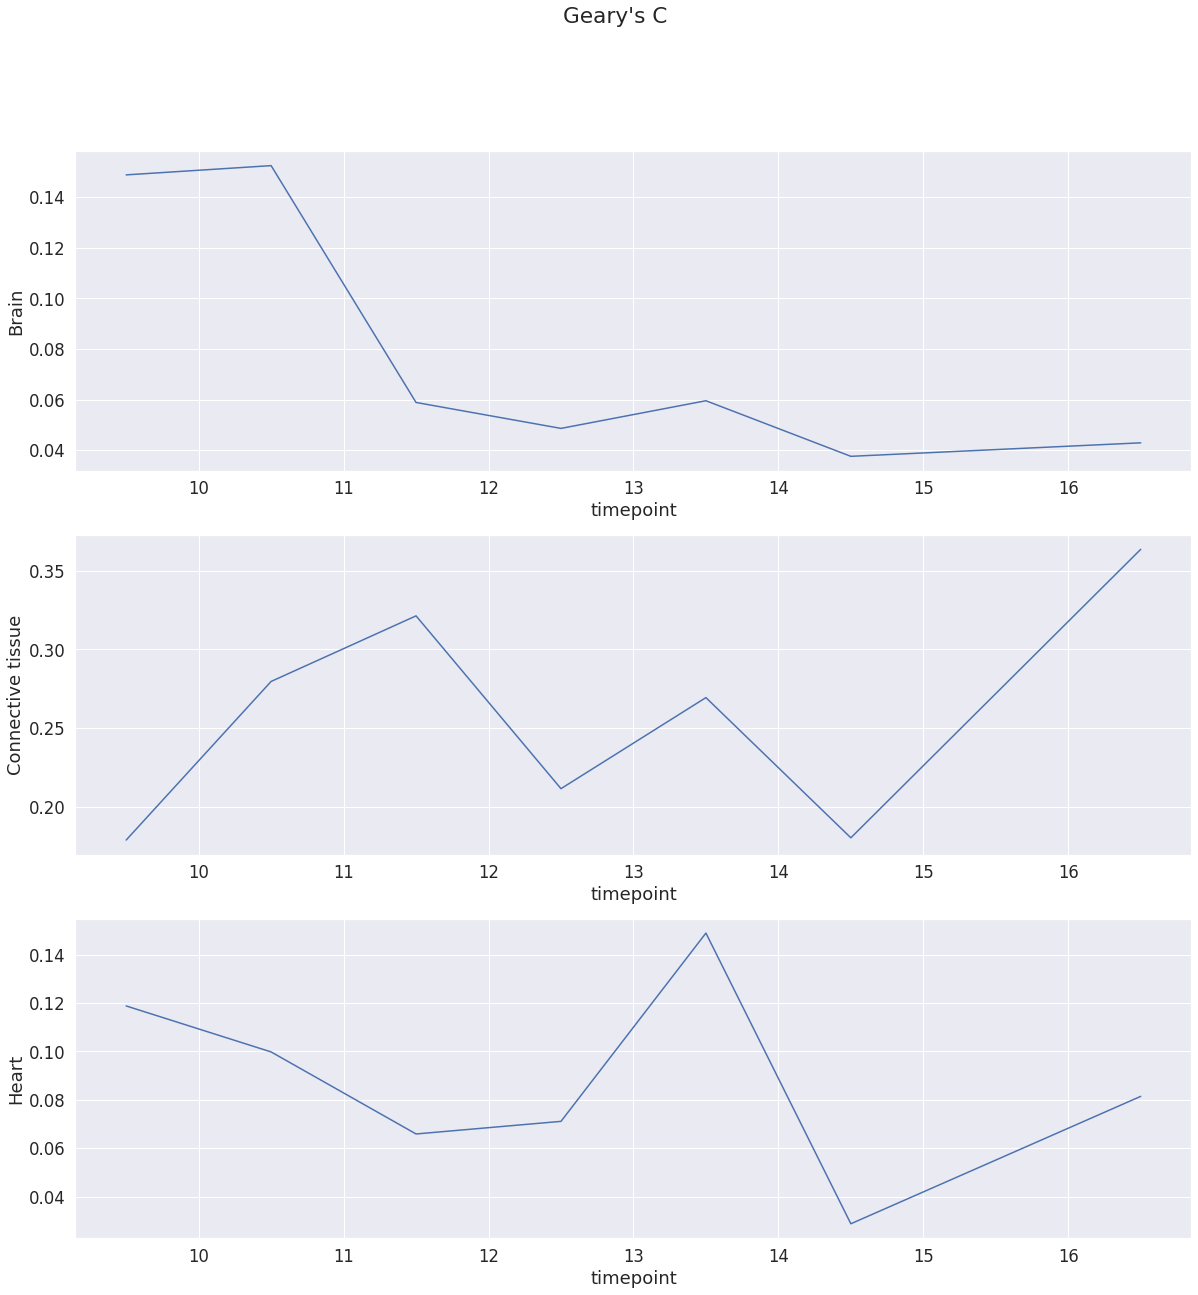

In [199]:
fig, axes = plt.subplots(3, figsize=(20,20))

sns.lineplot(data=gearys_c_dataframe, x="timepoint", y="Brain", ax=axes[0])
sns.lineplot(data=gearys_c_dataframe, x="timepoint", y="Connective tissue", ax=axes[1])
sns.lineplot(data=gearys_c_dataframe, x="timepoint", y="Heart", ax=axes[2])
plt.suptitle("Geary's C")
sns.set(font_scale=2)
# sns.set_style("white")
# fig, ax = plt.subplots()
# plt.plot(gearys_c_dataframe.timepoint, gearys_c_dataframe.Brain, "o-", ms=3,
#             color="r", label='Brain')
# plt.plot(gearys_c_dataframe.timepoint, gearys_c_dataframe.Heart, "o-", ms=3,
#             color="g", label='Heart')
# ax.legend()

In [216]:
data_directory = Path("../../data/stereoseq/mouse_embryo_development/")

for file in sorted(data_directory.glob("*.h5ad")):
    print(file)
    mouse_embryo_slice = ad.read_h5ad(file)

    brain_index = (mouse_embryo_slice.obs["annotation"] == "Brain")
    brain_filename = Path(f"{file.stem}_brain_region.h5ad")
    brain_slice = mouse_embryo_slice[brain_index]
    print(len(brain_slice))
    print(brain_filename)
    brain_slice.write(data_directory  / "brain_region" / brain_filename)

../../data/stereoseq/mouse_embryo_development/E10.5_E1S1.MOSTA.h5ad
2816
E10.5_E1S1.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E1S1.MOSTA_brain_region.h5ad
2816
E10.5_E1S1.MOSTA_brain_region_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E1S2.MOSTA.h5ad
3201
E10.5_E1S2.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E1S3.MOSTA.h5ad
2446
E10.5_E1S3.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E2S1.MOSTA.h5ad
589
E10.5_E2S1.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S1.MOSTA.h5ad
5794
E11.5_E1S1.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S2.MOSTA.h5ad
6481
E11.5_E1S2.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S3.MOSTA.h5ad
3897
E11.5_E1S3.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S4.MOSTA.h5ad
4745
E11.5_E1S4.MOSTA_brain_region.h5ad
../

In [217]:
ad.read_h5ad(data_directory  / "brain_region" / brain_filename)

AnnData object with n_obs × n_vars = 771 × 23398
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2610044O15Rik8', 'Regulon - AW146154', 'Regulon - Ahrr', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arnt2', 'Regulon - Arntl', 'Regulon - Arntl2', 'Regulon - Arx', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atoh7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Barx1', 'Regulon - Batf3', 'Regulon - Bcl3', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cdx4', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpd', 'Regulon - Cenpb', 'Regulon - Cers3', 'Regulon - Chd1', 'Regulon - Chd2', 'Regulon - Cic', 'Regulon - Clock', 'Regulon - Cpsf4', 'R